In [31]:
import os
import pickle
import itertools
import matplotlib.pyplot as plt
import numpy as np
import colorsys
from scipy.stats import sem

import sys
sys.path.append("/home/hamza97/MFRS")
from utils.config import similarity_folder
from plot_utils import get_layers_similarity

In [6]:
model_names = ["FaceNet", "SphereFace", "resnet50", "cornet_s"]
stimuli_file_names = ["Fam", "Unfam"]
activ_types = ["trained", "untrained"]
# Define a dictionary to map model names to indices
model_indices = {
    "SphereFace": 0,
    "FaceNet": 1,
    "resnet50": 2,
    "cornet_s": 3
}

# Define a nested dictionary to map combinations of activ_type and stimuli_file_name to offsets
combination_offsets = {
    ("trained", "Fam"): 0,
    ("trained", "Unfam"): 4,
    ("untrained", "Unfam"): 12,
    ("untrained", "Fam"): 8
}
combinations = list(itertools.product(model_names, stimuli_file_names, activ_types))

In [48]:
def get_bootstrap_values(bootstrap_data):
    boot_sem = {}
    for layer, values in bootstrap_data.items():
        boot_layer ={}
        for sensor_type, bootstrap_values in values.items():
            boot_layer[sensor_type] = sem(bootstrap_values)
        boot_sem[layer]=boot_layer
    return boot_sem 


In [49]:
results = np.zeros( (3, 16))
error_bars = np.zeros( (3, 16))

accuracy = [87.066, 90.679, 91.856, 75.908]
for combination in combinations:
    model_name, stimuli_file_name, activ_type = combination
    file = os.path.join(similarity_folder, f"{model_name}_{stimuli_file_name}_model_sim_scores_{activ_type}_avg.pkl")
    with open(file, 'rb') as file_data:
        data = pickle.load(file_data)
    layer_similarities, extremum_values = get_layers_similarity(data, ["model"], correlation_measure="pearson", epsilon=0.05)
    i = model_indices.get(model_name)  # Get the index from the dictionary, default to 3 if not found
    
    i += combination_offsets.get((activ_type, stimuli_file_name))  # Get the offset from the nested dictionary, default to 0 if not found

    results[0][i] = max(layer_similarities["model"][0])
    results[1][i] = max(layer_similarities["model"][1])
    results[2][i] = max(layer_similarities["model"][2])

    file = os.path.join(similarity_folder, f"{model_name}_{stimuli_file_name}_model_bootstrap_scores_{activ_type}_avg.pkl")
    with open(file, 'rb') as file_data:
        data = pickle.load(file_data)

    semdata = get_bootstrap_values(data)
    error_bars[0][i] = semdata["model"]["mag"]
    error_bars[1][i] = semdata["model"]["grad1"]
    error_bars[2][i] = semdata["model"]["grad2"]


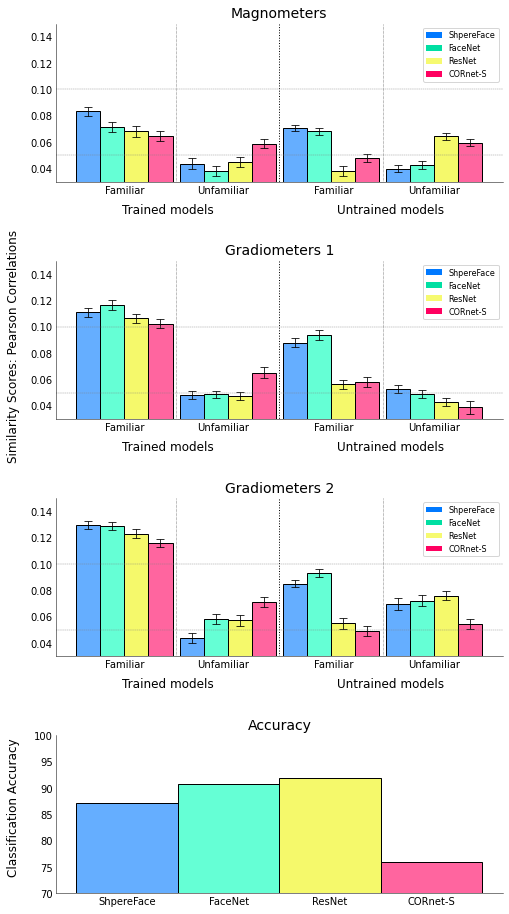

In [50]:
# Original colors from the Plasma color map
original_colors = [
    "#0079FF", "#00DFA2", "#F6FA70", "#FF0060",
    "#0079FF", "#00DFA2", "#F6FA70", "#FF0060",
    "#0079FF", "#00DFA2", "#F6FA70", "#FF0060",
    "#0079FF", "#00DFA2", "#F6FA70", "#FF0060",
]

# Define the desired lightness value (between 0 and 1)
lightness = 0.7

# Generate lighter shades of colors
lighter_colors = []
for color in original_colors:
    r, g, b = colorsys.rgb_to_hls(*tuple(int(color[i:i+2], 16) / 255.0 for i in (1, 3, 5)))
    r, g, b = colorsys.hls_to_rgb(r, lightness, b)
    lighter_colors.append('#%02x%02x%02x' % tuple(int(c * 255) for c in (r, g, b)))

# Use the lighter colors in your plot
block_colors = lighter_colors

# Define the titles for each block
block_titles = ['Magnometers', 'Gradiometers 1', 'Gradiometers 2', 'Accuracy']

# Create the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 16))

# Plot each block
for i, ax in enumerate(axes):
    ax.set_title(block_titles[i], fontsize=14)
    if i != 3:
        ax.set_ylim(0.03, 0.15)  # Adjust the y-axis limits as per your data range

        # Calculate total width required for each block
        block_width = 0.8
        num_bars = 16
        bar_width = block_width / num_bars
        error_values = error_bars[i]  # Array of size (3, 16)
        # Plot each bar within the block
        for j in range(16):
            x = j * bar_width + (0.015 * (j // 4))  # Calculate x-coordinate for each bar
            ax.bar(x, results[i][j], color=block_colors[j], edgecolor='black', width=bar_width)
            x = j * bar_width + (0.015 * (j // 4))  # Calculate x-coordinate for each bar
            y = results[i][j]
            error = error_values[j]
            ax.errorbar(x, y, yerr=error, color='black', capsize=4, elinewidth=0.8, capthick=0.8)

            # Add dotted separation line after every 4 bars
            if (j + 1) % 4 == 0 and j != 15:
                if j == 7:
                    ax.axvline(x + bar_width - 0.0175, ymin=-0.3, ymax=1, color='black', linestyle=':', linewidth=1.0)
                else:
                    ax.axvline(x + bar_width - 0.0175, color='black', linestyle=':', linewidth=0.5)
        

        # Add agenda axis
        ax.axhline(0.05, color='gray', linestyle='--', linewidth=0.4)
        ax.axhline(0.1, color='gray', linestyle='--', linewidth=0.4)

        ax.tick_params(axis='both', which='both', length=0, labelsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.set_xticks([0.075, 0.28, 0.51, 0.72])
        ax.set_xticklabels(['Familiar', 'Unfamiliar', 'Familiar', 'Unfamiliar'], fontsize=10)
        # Add text below the plot
        ax.text(0.25, -0.2, 'Trained models', transform=ax.transAxes, ha='center', fontsize=12)
        ax.text(0.75, -0.2, 'Untrained models', transform=ax.transAxes, ha='center', fontsize=12)
        legend_labels = ['ShpereFace', 'FaceNet', 'ResNet', 'CORnet-S']
        legend_colors = original_colors
        legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]
        ax.legend(legend_patches, legend_labels, loc='upper right', fontsize=8)
    else:
        ax.set_ylim(70, 100)  # Adjust the y-axis limits as per your data range
        # Calculate total width required for each block
        num_bars = 4
        bar_width = 0.8
        
        # Plot each bar within the block
        for j in range(4):
            x = j * bar_width  + (0.015 * (j // 4)) # Calculate x-coordinate for each bar
            ax.bar(x, accuracy[j], color=block_colors[j], edgecolor='black', width=bar_width)
        

        # # Add agenda axis
        # ax.axhline(0.05, color='gray', linestyle='--', linewidth=0.4)
        # ax.axhline(0.1, color='gray', linestyle='--', linewidth=0.4)

        ax.tick_params(axis='both', which='both', length=0, labelsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.set_xticks([0, 0.8, 1.6, 2.4])
        legend_labels = ['ShpereFace', 'FaceNet', 'ResNet', 'CORnet-S']

        ax.set_xticklabels(legend_labels, fontsize=10)
        # Add text below the plot
        # ax.text(0.25, -0.2, 'Trained models', transform=ax.transAxes, ha='center', fontsize=12)
        # ax.text(0.75, -0.2, 'Untrained models', transform=ax.transAxes, ha='center', fontsize=12)
        # legend_labels = ['ShpereFace', 'FaceNet', 'ResNet', 'CORnet-S']
        # legend_colors = original_colors
        # legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]
        # ax.legend(legend_patches, legend_labels, loc='upper right', fontsize=8)

# Add space between subplots
plt.subplots_adjust(hspace=0.5)

# Set overall plot title and labels
# plt.suptitle('My Scientific Poster', fontsize=16, y=0.95)
# fig.text(0.5, 0.04, 'X-axis Label', ha='center', fontsize=12)
fig.text(0.04, 0.6, 'Similarity Scores: Pearson Correlations', va='center', rotation='vertical', fontsize=12)
fig.text(0.04, 0.2, 'Classification Accuracy', va='center', rotation='vertical', fontsize=12)

# Display the plot
plt.show()
